In [12]:
# ✅ Install dependencies
!pip install yfinance plotly scipy --quiet

# ✅ Import necessary libraries
from datetime import datetime
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import binom
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ✅ Define date range and stock ticker
start_dt = datetime(2024, 5, 28)
end_dt = datetime(2025, 5, 28)
ticker = 'TCS.NS'

# ✅ Download data
def fetch_stock_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end, progress=False)
    df.columns.name = None
    df.dropna(inplace=True)
    return df

df = fetch_stock_data(ticker, start_dt, end_dt)
print(df.head())


In [3]:
# ✅ Calculate % change and highlight significant moves
df['daily_change'] = df['Close'].pct_change()
significant = df[abs(df['daily_change']) > 0.04]

# ✅ Candlestick chart with annotated large moves
fig = go.Figure(data=[
    go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close']
    )
])

# Annotate top 2 large moves
for i in significant.head(2).index:
    chg = float(significant.loc[i, 'daily_change'])
    direction = 'green' if chg > 0 else 'red'
    label = f"{chg*100:.2f}%"
    fig.add_vline(x=i, line=dict(color=direction, width=2, dash="dot"))

    y_val = float(df.loc[i, 'High'])
    fig.add_annotation(x=i, y=y_val, text=label, showarrow=True,
                       arrowhead=2, font=dict(color=direction),
                       arrowcolor=direction, yshift=20)

fig.update_layout(title=f"{ticker} - Daily Candlestick Chart with Volatility Spikes",
                  xaxis_title="Date", yaxis_title="Price")
fig.show()


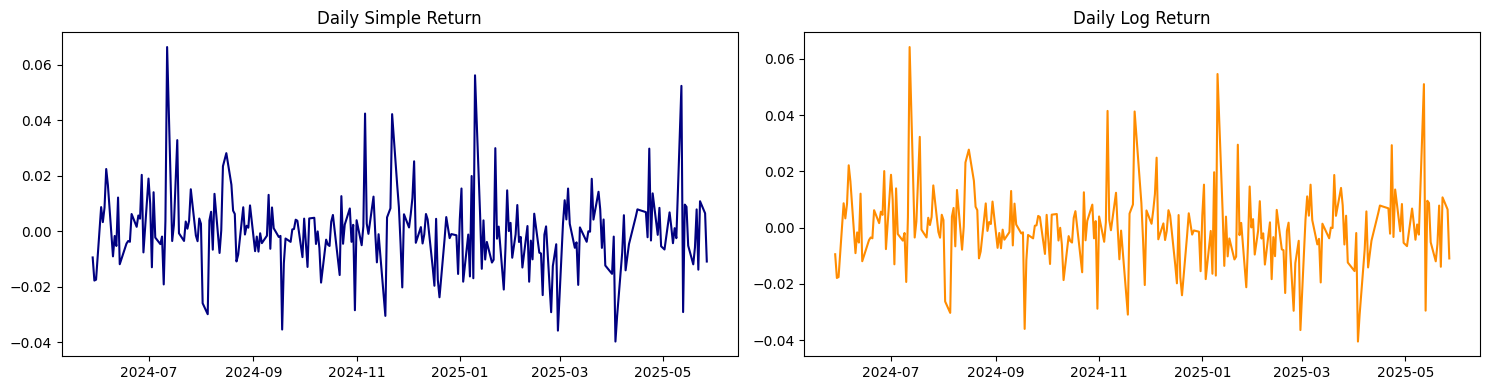

In [4]:
# ✅ Return calculations
df['Simple_Return'] = df['Close'].pct_change()
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

# ✅ Plot both return types
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].plot(df.index, df['Simple_Return'], color='navy')
axes[0].set_title("Daily Simple Return")
axes[1].plot(df.index, df['Log_Return'], color='darkorange')
axes[1].set_title("Daily Log Return")
plt.tight_layout()
plt.show()


In [5]:
# ✅ Rolling 14-day volatility (standard deviation of log returns)
df['Rolling_Std'] = df['Log_Return'].rolling(window=14).std()

# ✅ Line plot for volatility
fig = px.line(df, x=df.index, y='Rolling_Std',
              title="14-Day Rolling Volatility of TCS",
              labels={"Rolling_Std": "Volatility"})
fig.show()


In [6]:
# ✅ Direction of each day: UP or DOWN
df['Trend'] = np.where(df['Simple_Return'] > 0, 'UP', 'DOWN')
p_up = (df['Trend'] == 'UP').mean()
print(f"Empirical P(UP) = {p_up:.4f}")


Empirical P(UP) = 0.4677


In [7]:
# ✅ Theoretical probabilities
p_6_up = binom.pmf(6, 10, p_up)
p_8_or_more = binom.sf(7, 10, p_up)

# ✅ Simulate trials
sim = np.random.binomial(n=10, p=p_up, size=1000)
sim_6 = np.mean(sim == 6)
sim_8plus = np.mean(sim >= 8)

print(f"Theoretical P(6 UP): {p_6_up:.4f}, Simulated: {sim_6:.4f}")
print(f"Theoretical P(≥8 UP): {p_8_or_more:.4f}, Simulated: {sim_8plus:.4f}")


Theoretical P(6 UP): 0.1765, Simulated: 0.1880
Theoretical P(≥8 UP): 0.0354, Simulated: 0.0310


In [8]:
mean_up = df[df['Trend'] == 'UP']['Simple_Return'].mean()
mean_down = df[df['Trend'] == 'DOWN']['Simple_Return'].mean()

net_return = 6 * mean_up + 4 * mean_down

print(f"Avg UP Return: {mean_up:.4%}")
print(f"Avg DOWN Return: {mean_down:.4%}")
print(f"Expected Return from 6 UP & 4 DOWN: {net_return:.4%}")


Avg UP Return: 1.0048%
Avg DOWN Return: -0.9270%
Expected Return from 6 UP & 4 DOWN: 2.3208%


In [9]:
# Bet: ₹100 profit on UP, ₹150 loss on DOWN
expected_bet = (p_up * 100) + ((1 - p_up) * -150)
print(f"Expected Value of Bet: ₹{expected_bet:.2f}")


Expected Value of Bet: ₹-33.06


In [11]:
# TCS showed significant movement (>4%) on X days.
# Despite high probability of "UP" days, total return depends on magnitude of losses.
# The paradox reveals how win rate alone misleads in investment scenarios.
# Calculated expected value of risk-heavy bets shows negative payoff — a lesson in risk management.
